In [109]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install gymnasium[all]
!pip install ale-py
!pip install stable_baselines3
!pip install pyvirtualdisplay

#Tests sur l'environnement

(400, 600, 3)


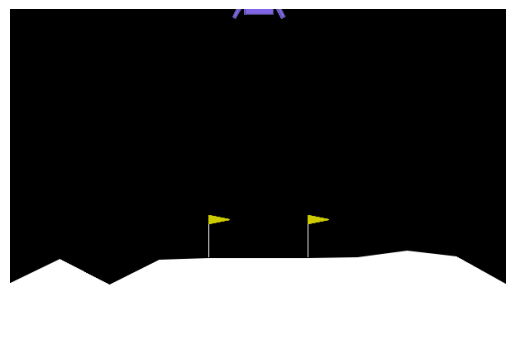

Nombre d'inforamtions par état: 8, nombre d'actions possibles: 4


In [226]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make('LunarLander-v3', render_mode='rgb_array')
observation, info = env.reset()

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
frame = env.render()
print(frame.shape)

plt.imshow(frame)
plt.axis("off")
plt.show()

STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n
print(f"Nombre d'inforamtions par état: {STATE_DIM}, nombre d'actions possibles: {ACTION_DIM}")

# Deep Q-learning avec MLP

Définitions des paramètres du modèle

In [81]:
# Hyperparamètres
GAMMA = 0.99           # Facteur de discount
LR = 1e-3              # Taux d'apprentissage
BATCH_SIZE = 64        # Taille des lots pour l'entraînement
MEMORY_SIZE = 100000   # Taille du replay buffer
EPSILON_START = 1.0    # Valeur initiale pour epsilon (exploration)
EPSILON_END = 0.01     # Valeur finale pour epsilon
EPSILON_DECAY = 0.995  # Facteur de décroissance pour epsilon
TARGET_UPDATE = 10     # Fréquence de mise à jour du réseau cible

Création de l'architecture fully connected

In [224]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class MLPQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(MLPQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Initialiser les réseaux
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_mlp = MLPQNetwork(STATE_DIM, ACTION_DIM).to(device)
target_mlp = MLPQNetwork(STATE_DIM, ACTION_DIM).to(device)
target_mlp.load_state_dict(policy_mlp.state_dict())
target_mlp.eval()

from torchsummary import summary

summary(target_mlp, (8, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,152
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 4]             516
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


Création de la mémoire tampon pour stocker les transitions

In [216]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)

# Initialiser le buffer
replay_buffer = ReplayBuffer(MEMORY_SIZE)

Boucle d'entrainement du modèle

In [221]:
# Optimiseur
optimizer = optim.Adam(policy_mlp.parameters(), lr=LR)
epsilon = EPSILON_START

def compute_loss(batch):
    states, actions, rewards, next_states, dones = batch

    # Q-valeurs actuelles
    q_values = policy_mlp(states).gather(1, actions)

    # Q-valeurs cibles
    with torch.no_grad():
        max_next_q_values = target_mlp(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values

    # Perte (MSE)
    loss = nn.MSELoss()(q_values, target_q_values)
    return loss

# Entraînement
num_episodes = 500
episode_reward = []
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0

    for t in range(1000):
        # Choisir une action (epsilon-greedy)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_mlp(state).argmax().item()

        # Exécuter l'action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(state.cpu().numpy(), action, reward, next_state, done)
        state = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_reward += reward

        # Entraînement
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = compute_loss(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Mettre à jour le réseau cible
        if t % TARGET_UPDATE == 0:
            target_mlp.load_state_dict(policy_mlp.state_dict())

        if done:
            break

    episode_reward.append(total_reward)

    # Décroissance de epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    #Affichage de la récompense moyenne toutes les k itérations
    k = 50
    if (episode + 1)%k == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {sum(episode_reward[-k:])/k}")

env.close()

torch.save(policy_mlp.state_dict(), 'policy_cnn.pth')
torch.save(target_mlp.state_dict(), 'target_cnn.pth')

Episode 50/500, Reward: -157.1896212755131
Episode 100/500, Reward: -92.51916439194288
Episode 150/500, Reward: -71.55353027902984
Episode 200/500, Reward: -57.288235765931425
Episode 250/500, Reward: -41.590290334289186
Episode 300/500, Reward: -15.170071546356708
Episode 350/500, Reward: 31.68029159515569
Episode 400/500, Reward: 116.217665736417
Episode 450/500, Reward: 15.3895117605409
Episode 500/500, Reward: 61.53991412508457


Affichage des récompenses au cours de l'entrainement

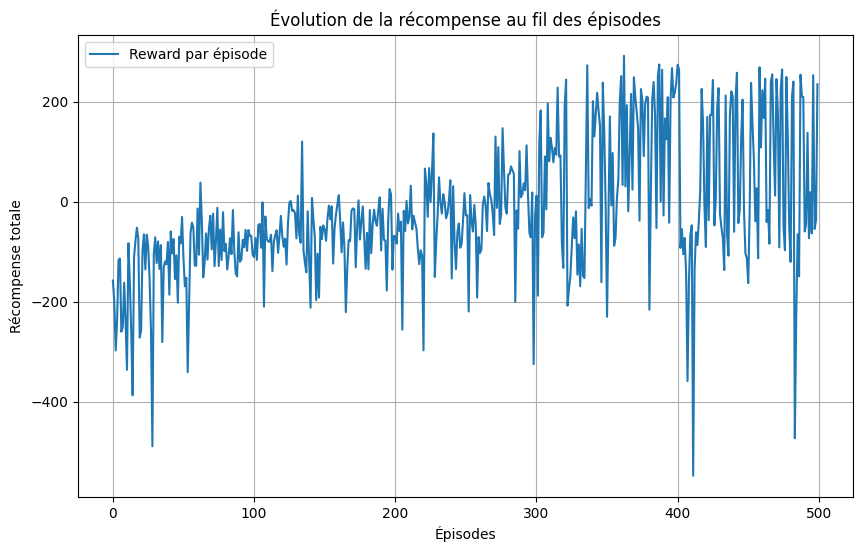

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(len(episode_reward)), episode_reward, label="Reward par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense totale")
plt.title("Évolution de la récompense au fil des épisodes")
plt.legend()
plt.grid()
plt.show()

Test du modèle sur plusieurs épisodes

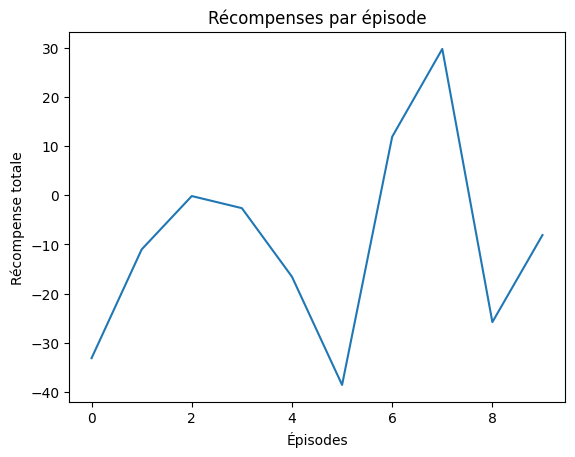

[-33.124941019363604, -11.021768424261287, -0.17606079989426515, -2.6359152081610846, -16.576166399117817, -38.56689930826783, 11.87549293486823, 29.731905852970918, -25.79589956114379, -8.101488366544574]


In [223]:
import matplotlib.pyplot as plt

episode_rewards = []

for episode in range(10):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    done = False
    total_reward = 0

    while not done:
        with torch.no_grad():
            action = policy_mlp(state).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_reward += reward
        env.render()

    env.close()

    episode_rewards.append(total_reward)

plt.plot(episode_rewards)
plt.title("Récompenses par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense totale")
plt.show()
print(episode_rewards)

Enregistrement d'une vidéo pour observer le comportement du modèle

In [86]:
import imageio

frames = []

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32).to(device)
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        action = policy_mlp(state).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = torch.tensor(next_state, dtype=torch.float32).to(device)

    frames.append(env.render())
    total_reward += reward

env.close()
print(total_reward)
video_filename = "test_run.mp4"
imageio.mimsave(video_filename, frames, fps=30)

239.3813750652661


# Deep Q-learning avec CNN

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
'''
import ale_py
gym.register_envs(ale_py)
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
'''
env = gym.make('LunarLander-v3', render_mode='rgb_array')
observation, info = env.reset()

In [235]:
# Paramètres d'entraînement
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 4
MEMORY_SIZE = 100000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE = 10

Pré-traitement des images récupérées vers une taille de 84x84


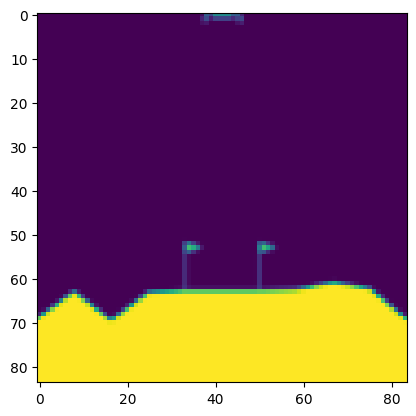

In [227]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

frame = env.render()
preprocessed_frame = transform(frame).squeeze()
plt.imshow(preprocessed_frame)
plt.show()

Empiler 4 frames pour que le modèle comprenne la séquence

In [237]:
from collections import deque

stacked_frames = deque(maxlen=4)

def stack_frames(frame, is_new_episode):
    if is_new_episode:
        # Empile 4 fois la même frame si c'est la 1ère
        for _ in range(4):
            stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)

    return np.stack(stacked_frames, axis=0)


stacked_frame = stack_frames(preprocessed_frame, is_new_episode=True)
print(stacked_frame.shape)

(4, 84, 84)


In [229]:
class CNNQNetwork(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(CNNQNetwork, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=8, stride=4, padding=0)  # 16 cartes, filtre 8x8
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0)  # 32 cartes, filtre 4x4
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)  # 64 cartes, filtre 3x3
        self.relu3 = nn.ReLU()

        self.flatten_size = 64 * 7 * 7  # 64 cartes de taille 7x7 après les convolutions

        self.fc4 = nn.Linear(self.flatten_size, 256)  # 256 unités cachées
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(256, action_dim)  # Sortie pour chaque action possible

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = self.relu4(self.fc4(x))
        x = self.fc5(x)

        return x

policy_cnn = CNNQNetwork(input_channels=4, action_dim=ACTION_DIM).to(device)
target_cnn = CNNQNetwork(input_channels=4, action_dim=ACTION_DIM).to(device)
target_cnn.load_state_dict(policy_cnn.state_dict())
target_cnn.eval()

from torchsummary import summary

summary(target_cnn, (4, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 20, 20]           4,112
              ReLU-2           [-1, 16, 20, 20]               0
            Conv2d-3             [-1, 32, 9, 9]           8,224
              ReLU-4             [-1, 32, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
              ReLU-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 256]         803,072
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 4]           1,028
Total params: 834,932
Trainable params: 834,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.19
Params size (MB): 3.19
Estimated Total Size (MB): 3.48
-------------------------------------------

mémoire tampon pour le modèle

In [230]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        frames, actions, rewards, next_frames, dones = zip(*samples)
        return (
            torch.tensor(frames, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(next_frames, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)

# Initialiser le buffer
replay_buffer = ReplayBuffer(MEMORY_SIZE)

Limitation des récompenses et fonction de loss

In [231]:
def clip_reward(reward, min_reward=-1, max_reward=1):
    return np.clip(reward, min_reward, max_reward)

# Fonction de perte
def compute_loss(batch):
    states, actions, rewards, next_states, dones = batch

    # Q-valeurs actuelles
    q_values = policy_cnn(states).gather(1, actions)

    # Q-valeurs cibles
    with torch.no_grad():
        max_next_q_values = target_cnn(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values

    # Perte (MSE)
    loss = nn.MSELoss()(q_values, target_q_values)
    return loss


Boucle d'entrainement

In [238]:
# Entraînement
num_episodes = 1000
epsilon = EPSILON_START
optimizer = optim.Adam(policy_cnn.parameters(), lr=LR)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

episode_reward = []
for episode in range(num_episodes):
    _, _ = env.reset()
    frame = env.render()
    frame = transform(frame).squeeze()
    frame = stack_frames(frame, is_new_episode=True)
    frame = torch.tensor(frame, dtype=torch.float32).to(device)
    total_reward = 0

    for t in range(1000):
        # Choisir une action (epsilon-greedy)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_cnn(frame.unsqueeze(0)).argmax().item()  # unsqueeze() pour ajouter la dimension de batch

        # Exécuter l'action
        next_state, reward, terminated, truncated, _ = env.step(action)
        reward = clip_reward(reward)
        done = terminated or truncated

        # Récupérer l'image du jeu
        next_frame = env.render()
        next_frame = transform(next_frame).squeeze()
        next_frame = stack_frames(next_frame, is_new_episode=True)
        next_frame = torch.tensor(next_frame, dtype=torch.float32).to(device)

        replay_buffer.push(frame.numpy(), action, reward, next_frame.numpy(), done)
        frame = next_frame
        total_reward += reward

        # Entraînement
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = compute_loss(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Mettre à jour le réseau cible
        if t % TARGET_UPDATE == 0:
            target_cnn.load_state_dict(policy_cnn.state_dict())

        if done:
            break

    episode_reward.append(total_reward)

    # Décroissance de epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    #Affichage de la récompense moyenne toutes les k itérations
    k = 2
    if (episode + 1)%k == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Reward: {sum(episode_reward[-k:])/k}")

env.close()

torch.save(policy_cnn.state_dict(), 'policy_cnn.pth')
torch.save(target_cnn.state_dict(), 'target_cnn.pth')

Episode 2/50, Reward: -28.926333233736834
Episode 4/50, Reward: -25.706602567411686
Episode 6/50, Reward: -22.478934295586463
Episode 8/50, Reward: -53.78133770647633
Episode 10/50, Reward: -37.51702493569768
Episode 12/50, Reward: -61.03559154410061


KeyboardInterrupt: 

Affichage des récompenses au cours de l'entrainement

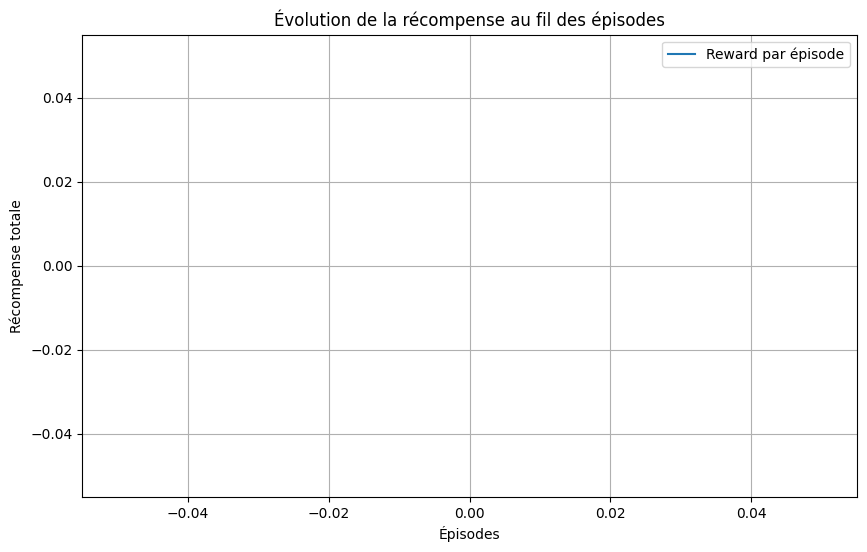

In [234]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(episode_reward)), episode_reward, label="Reward par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense totale")
plt.title("Évolution de la récompense au fil des épisodes")
plt.legend()
plt.grid()
plt.show()

Test du modèle sur plusieurs épisodes

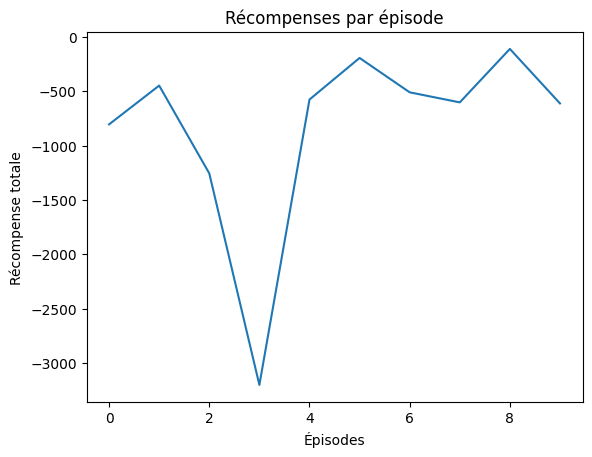

[-805.2448271845986, -448.50007048593966, -1256.3135618349263, -3202.4431009067853, -576.8821796486943, -194.20818994422876, -510.4720013577588, -602.874843561741, -111.1146176167835, -612.5392463004636]


In [209]:
episode_rewards = []

for episode in range(10):
    state, _ = env.reset()
    frame = env.render()
    frame = transform(frame).squeeze()
    frame = stack_frames(frame, is_new_episode=True)
    frame = torch.tensor(frame, dtype=torch.float32).to(device)
    done = False
    total_reward = 0

    while not done:
        with torch.no_grad():
            action = policy_cnn(frame.unsqueeze(0)).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = torch.tensor(next_state, dtype=torch.float32).to(device)
        total_reward += reward
        env.render()

    env.close()

    episode_rewards.append(total_reward)

plt.plot(episode_rewards)
plt.title("Récompenses par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense totale")
plt.show()
print(episode_rewards)

Enregistrement d'une vidéo pour observer le comportement du modèle

In [213]:
import imageio

frames = []

state, _ = env.reset()
frame = env.render()
frame = transform(frame).squeeze()
frame = stack_frames(frame, is_new_episode=True)
frame = torch.tensor(frame, dtype=torch.float32).to(device)
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        action = policy_cnn(frame.unsqueeze(0)).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = torch.tensor(next_state, dtype=torch.float32).to(device)

    frames.append(env.render())
    total_reward += reward

env.close()
print(total_reward)
video_filename = "test_run.mp4"
imageio.mimsave(video_filename, frames, fps=30)

-340.91445955707
